# FGSM을 이용한 적대적 샘플 생성

이 튜토리얼에서는 Ian Goodfellow *et al*의 [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572)에 기술된 FGSM(Fast Gradient Signed Method)을 이용해 적대적 샘플(adversarial example)을 생성하는 방법에 대해 소개합니다. FGSM은 신경망 공격 기술들 중 초기에 발견된 방법이자 가장 유명한 방식 중 하나입니다.

## 적대적 샘플이란?

적대적 샘플이란 신경망을 혼란시킬 목적으로 만들어진 특수한 입력으로, 신경망으로 하여금 샘플을 잘못 분류하도록 합니다. 비록 인간에게 적대적 샘플은 일반 샘플과 큰 차이가 없어보이지만, 신경망은 적대적 샘플을 올바르게 식별하지 못합니다. 이와 같은 신경망 공격에는 여러 종류가 있는데, 본 튜토리얼에서는 화이트 박스(white box) 공격 기술에 속하는 FGSM을 소개합니다. 화이트 박스 공격이란 공격자가 대상 모델의 모든 파라미터값에 접근할 수 있다는 가정 하에 이루어지는 공격을 일컫습니다. 아래 이미지는 Goodfellow et al에 소개된 가장 유명한 적대적 샘플인 판다의 사진입니다.

![Adversarial Example](images/adversarial_example.png)

원본 이미지에 특정한 작은 왜곡을 추가하면 신경망으로 하여금 판다를 높은 신뢰도로 긴팔 원숭이로 잘못 인식하도록 만들 수 있습니다. 이하 섹션에서는 이 왜곡 추가 과정에 대해 살펴보도록 하겠습니다.

## FGSM

FGSM은 신경망의 그래디언트(gradient)를 이용해 적대적 샘플을 생성하는 기법입니다. 만약 모델의 입력이 이미지라면, 입력 이미지에 대한 손실 함수의 그래디언트를 계산하여 그 손실을 최대화하는 이미지를 생성합니다. 이처럼 새롭게 생성된 이미지를 적대적 이미지(adversarial image)라고 합니다. 이 과정은 다음과 같은 수식으로 정리할 수 있습니다:

$$adv_x = x + \epsilon*\text{sign}(\nabla_xJ(\theta, x, y))$$

- adv_x : 적대적 이미지.
- x : 원본 입력 이미지.
- y : 원본 입력 레이블(label).
- $\epsilon$ : 왜곡의 양을 적게 만들기 위해 곱하는 수.
- $\theta$ : 모델의 파라미터.
- $J$ : 손실 함수.

각 기호에 대한 설명은 다음과 같습니다.

여기서 흥미로운 사실은 입력 이미지에 대한 그래디언트가 사용된다는 점입니다. 이는 손실을 최대화하는 이미지를 생성하는 것이 FGSM의 목적이기 때문입니다. 요약하자면, 적대적 샘플은 각 픽셀의 손실에 대한 기여도를 그래디언트를 통해 계산한 후, 그 기여도에 따라 픽셀값에 왜곡을 추가함으로써 생성할 수 있습니다. 각 픽셀의 기여도는 연쇄 법칙(chain rule)을 이용해 그래디언트를 계산하는 것으로 빠르게 파악할 수 있습니다. 이것이 입력 이미지에 대한 그래디언트가 쓰이는 이유입니다. 또한, 대상 모델은 더 이상 학습하고 있지 않기 때문에 (따라서 신경망의 가중치에 대한 그래디언트는 필요하지 않습니다) 모델의 가중치값은 변하지 않습니다. FGSM의 궁극적인 목표는 이미 학습을 마친 상태의 모델을 혼란시키는 것입니다.

In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

사전 훈련된 MobileNetV2 모델과 ImageNet의 클래스(class) 이름들을 불러옵니다.

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet 클래스 레이블
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [ ]:
# 이미지가 MobileNetV2에 전달될 수 있도록 전처리해주는 헬퍼 메서드(helper function)
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = image/255
  image = tf.image.resize(image, (224, 224))
  image = image[None, ...]
  return image

# 확률 벡터에서 레이블을 추출해주는 헬퍼 메서드
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## 원본 이미지

Mirko [CC-BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/)의 [래브라도 리트리버](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg) 샘플 이미지를 이용해 적대적 샘플을 생성합니다. 첫 단계로, 원본 이미지를 전처리하여 MobileNetV2 모델에 입력으로 제공합니다.

In [4]:
import numpy as np
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)
print(np.argmax(image_probs, axis=1))

[208]


이미지를 살펴봅시다.

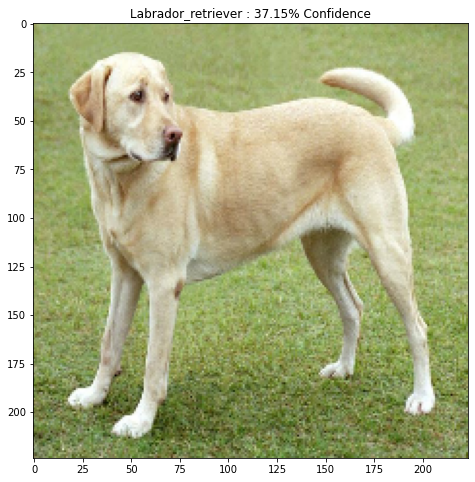

In [5]:
plt.figure()
plt.imshow(image[0])
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## 적대적 이미지 생성하기

### FGSM 실행하기

첫번째 단계는 샘플 생성을 위해 원본 이미지에 가하게 될 왜곡을 생성하는 것입니다. 앞서 살펴보았듯이, 왜곡을 생성할 때에는 입력 이미지에 대한 그래디언트를 사용합니다.

In [6]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    print(prediction.shape)
    loss = loss_object(input_label, prediction)
    print(loss)

  # 입력 이미지에 대한 손실 함수의 기울기를 구합니다.
  gradient = tape.gradient(loss, input_image)
  print(gradient.shape)
  # 왜곡을 생성하기 위해 그래디언트의 부호를 구합니다.
  signed_grad = tf.sign(gradient)
  print(signed_grad.shape)
  return signed_grad

생성한 왜곡을 시각화해 볼 수 있습니다.

(1, 1000)
tf.Tensor(0.9861309, shape=(), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3)
(1, 224, 224, 3)


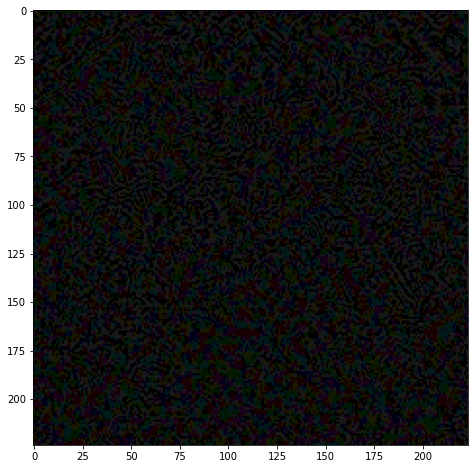

In [7]:
# 이미지의 레이블을 원-핫 인코딩 처리합니다.
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
# print(label.shape)
label = tf.reshape(label, (1, image_probs.shape[-1]))
# print(label.shape)
# print(label)
perturbations = create_adversarial_pattern(image, label)
# print(perturbations[0,:10,:10,:])
plt.imshow(perturbations[0]*0.1)

왜곡 승수 엡실론(epsilon)을 바꿔가며 다양한 값들을 시도해봅시다. 위의 간단한 실험을 통해 엡실론의 값이 커질수록 네트워크를 혼란시키는 것이 쉬워짐을 알 수 있습니다. 하지만 이는 이미지의 왜곡이 점점 더 뚜렷해진다는 단점을 동반합니다.

In [8]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0])
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

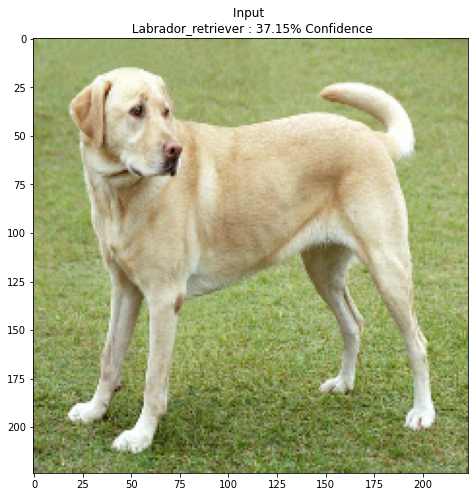

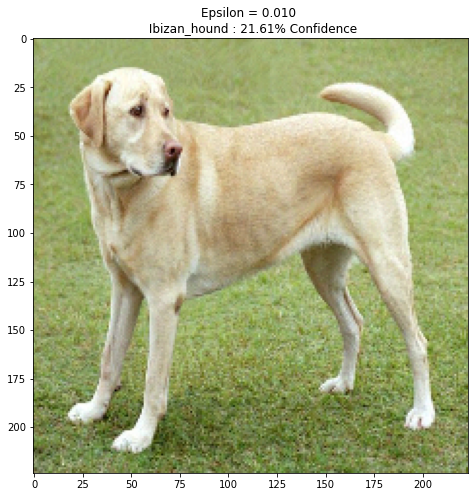

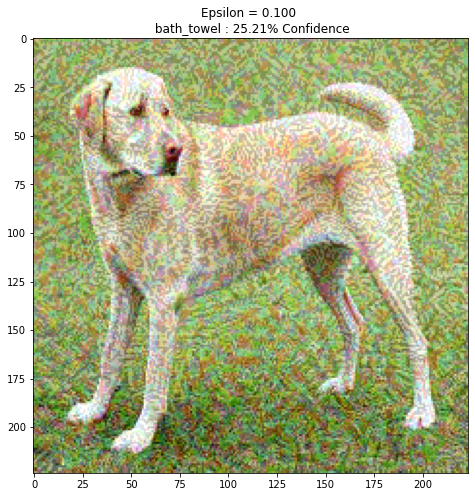

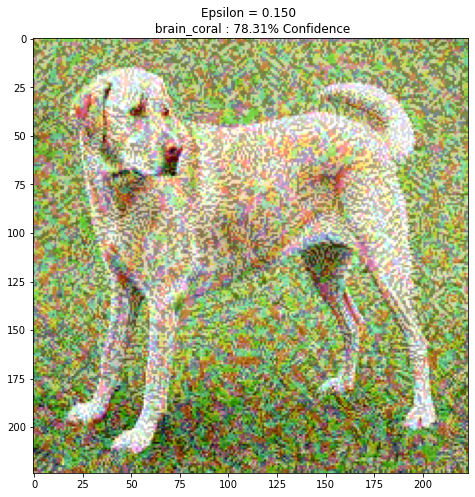

In [9]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, 0, 1)
  display_images(adv_x, descriptions[i])

## 다음 단계

이 튜토리얼에서 적대적 공격에 대해서 알아보았으니, 이제는 이 기법을 다양한 데이터넷과 신경망 구조에 시험해볼 차례입니다. 새로 만든 모델에 FGSM을 시도해보는 것도 가능할 것입니다. 엡실론 값을 바꿔가며 신경망의 샘플 신뢰도가 어떻게 변하는지 살펴볼 수도 있습니다.

FGSM은 그 자체로도 강력한 기법이지만 이후 다른 연구들에서 발견된 보다 더 효과적인 적대적 공격 기술들의 시작점에 불과합니다. 또한, FGSM의 발견은 적대적 공격 뿐만 아니라 더 견고한 기계 학습 모델을 만들기 위한 방어 기술에 대한 연구도 촉진시켰습니다. 적대적 공격과 방어 기술에 대한 전반적인 조망은 이 [문헌](https://arxiv.org/abs/1810.00069)에서 볼 수 있습니다.

다양한 적대적 공격과 방어 기술의 구현 방법이 궁금하다면, 적대적 샘플 라이브러리 [CleverHans](https://github.com/tensorflow/cleverhans)를 참고합니다.